In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim
import pandas as pd

In [2]:
# Paths to the data
initial_samples_folder = '/home/wfarz001/Fall-2024_Project/Tumor_States/Initial/'
final_samples_folder = '/home/wfarz001/Fall-2024_Project/Tumor_States/Final/'

In [3]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

class TumorDataset(Dataset):
    def __init__(self, initial_dir, final_dir, transform=None):
        self.initial_dir = initial_dir
        self.final_dir = final_dir
        self.transform = transform
        self.initial_files = sorted(os.listdir(initial_dir))  # List of initial state files
        self.final_files = sorted(os.listdir(final_dir))  # List of final state files
        
    def __len__(self):
        return len(self.initial_files)
    
    def __getitem__(self, idx):
        initial_file = os.path.join(self.initial_dir, self.initial_files[idx])
        final_file = os.path.join(self.final_dir, self.final_files[idx])
        
        initial_sample = np.load(initial_file)  # Assuming .npy format
        final_sample = np.load(final_file)  # Assuming .npy format
        
        # Convert to torch tensors
        initial_sample = torch.tensor(initial_sample, dtype=torch.float32)
        final_sample = torch.tensor(final_sample, dtype=torch.float32)
        
        if self.transform:
            initial_sample = self.transform(initial_sample)
            final_sample = self.transform(final_sample)
        
        return initial_sample, final_sample

# Create dataset and split it into train, validation, and test
dataset = TumorDataset(initial_samples_folder, final_samples_folder)
train_data, test_data = train_test_split(dataset, test_size=0.3, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

train_loader = DataLoader(train_data, batch_size=4, shuffle=True)
val_loader = DataLoader(val_data, batch_size=4, shuffle=False)
test_loader = DataLoader(test_data, batch_size=4, shuffle=False)


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TumorGrowthCNN(nn.Module):
    def __init__(self):
        super(TumorGrowthCNN, self).__init__()
        # Expect 1 input channel (after adding channel dimension)
        self.conv1 = nn.Conv3d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm3d(16)
        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm3d(32)
        self.conv3 = nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm3d(64)
        self.conv4 = nn.Conv3d(64, 1, kernel_size=1)  # Output: 1 channel

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.conv4(x)
        return x

In [19]:
learning_rate = 0.001
epochs = 10

# Model, Loss, and Optimizer
model = TumorGrowthCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [20]:
# Initialize dataset and dataloaders
dataset = TumorDataset(initial_samples_folder, final_samples_folder)
train_loader = DataLoader(train_data, batch_size=4, shuffle=True)
val_loader = DataLoader(val_data, batch_size=4, shuffle=False)
test_loader = DataLoader(test_data, batch_size=4, shuffle=False)

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model, optimizer, and loss function
model = TumorGrowthCNN().to(device)  # Ensure to place model on GPU if available
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

# Training loop with validation
num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for initial_sample, final_sample in train_loader:
        initial_sample, final_sample = initial_sample.to(device), final_sample.to(device)

        optimizer.zero_grad()
        predicted_final_state = model(initial_sample.unsqueeze(1))  # Add channel dimension (1 for grayscale)
        
        # Compute loss and backpropagate
        loss = loss_fn(predicted_final_state, final_sample.unsqueeze(1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Validation phase after each epoch
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    with torch.no_grad():
        for initial_sample, final_sample in val_loader:
            initial_sample, final_sample = initial_sample.to(device), final_sample.to(device)
            predicted_final_state = model(initial_sample.unsqueeze(1))
            loss = loss_fn(predicted_final_state, final_sample.unsqueeze(1))
            val_loss += loss.item()

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {total_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(val_loader):.4f}')


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:605: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv3d(


Epoch 1/500, Train Loss: 0.0195, Validation Loss: 0.0081
Epoch 2/500, Train Loss: 0.0034, Validation Loss: 0.0049
Epoch 3/500, Train Loss: 0.0026, Validation Loss: 0.0031
Epoch 4/500, Train Loss: 0.0025, Validation Loss: 0.0019
Epoch 5/500, Train Loss: 0.0023, Validation Loss: 0.0020
Epoch 6/500, Train Loss: 0.0023, Validation Loss: 0.0022
Epoch 7/500, Train Loss: 0.0022, Validation Loss: 0.0020
Epoch 8/500, Train Loss: 0.0022, Validation Loss: 0.0016
Epoch 9/500, Train Loss: 0.0021, Validation Loss: 0.0016
Epoch 10/500, Train Loss: 0.0020, Validation Loss: 0.0016
Epoch 11/500, Train Loss: 0.0020, Validation Loss: 0.0015
Epoch 12/500, Train Loss: 0.0022, Validation Loss: 0.0016
Epoch 13/500, Train Loss: 0.0021, Validation Loss: 0.0015
Epoch 14/500, Train Loss: 0.0022, Validation Loss: 0.0017
Epoch 15/500, Train Loss: 0.0022, Validation Loss: 0.0020
Epoch 16/500, Train Loss: 0.0021, Validation Loss: 0.0023
Epoch 17/500, Train Loss: 0.0024, Validation Loss: 0.0014
Epoch 18/500, Train Los

In [25]:
# Evaluate the final model on the test data
model.eval()  # Set the model to evaluation mode
test_loss = 0
with torch.no_grad():
    for initial_sample, final_sample in test_loader:
        initial_sample, final_sample = initial_sample.to(device), final_sample.to(device)
        predicted_final_state = model(initial_sample.unsqueeze(1))
        loss = loss_fn(predicted_final_state, final_sample.unsqueeze(1))
        test_loss += loss.item()

print(f'Test Loss: {test_loss/len(test_loader):.4f}')

Test Loss: 0.0014


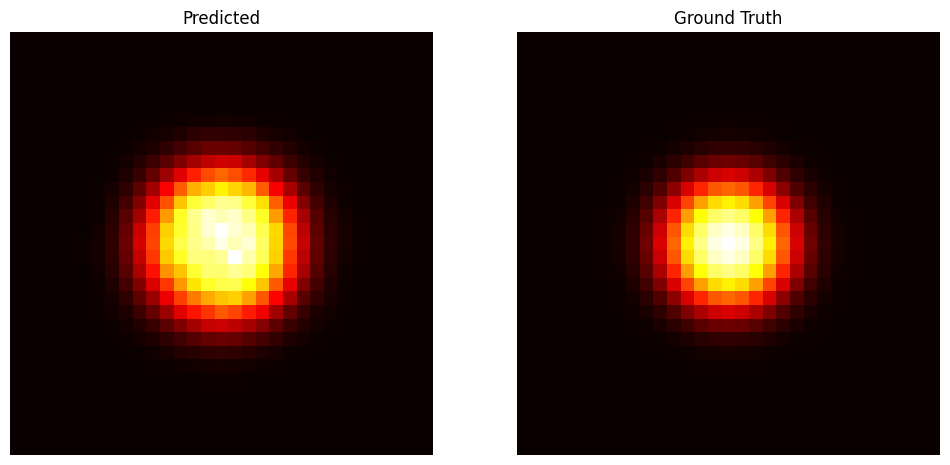

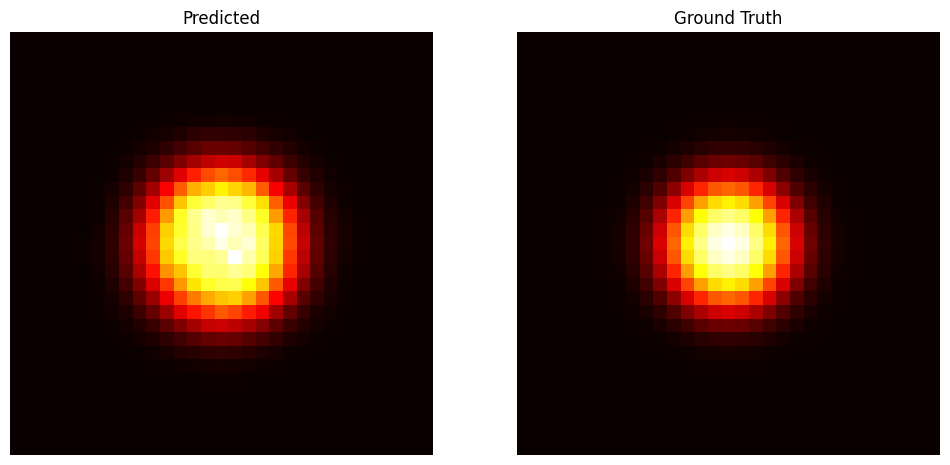

In [27]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Visualize predictions on the test set
def plot_3d_slice(predicted, ground_truth, sample_index=0, slice_index=15):
    predicted_slice = predicted[sample_index, 0, slice_index, :, :].detach().cpu().numpy()  # For predicted tensor with channel dimension
    ground_truth_slice = ground_truth[sample_index, slice_index, :, :].detach().cpu().numpy()  # For ground truth tensor without channel dimension

    # Plotting
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(predicted_slice, cmap='hot', interpolation='nearest')
    ax[0].set_title("Predicted")
    ax[0].axis('off')

    ax[1].imshow(ground_truth_slice, cmap='hot', interpolation='nearest')
    ax[1].set_title("Ground Truth")
    ax[1].axis('off')

    plt.show()

# Example usage with a sample index of 0 and a slice index of 15
model.eval()
with torch.no_grad():
    for initial_sample, final_sample in test_loader:
        initial_sample, final_sample = initial_sample.to(device), final_sample.to(device)
        predicted_final_state = model(initial_sample.unsqueeze(1))

        # Visualize the first sample and slice
        plot_3d_slice(predicted_final_state, final_sample, sample_index=0, slice_index=15)
        break  # Just plot one batch for demonstration


In [28]:
!pip install pytorch-msssim


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [29]:
def rmse(predictions, targets):
    return torch.sqrt(torch.mean((predictions - targets) ** 2))

def mae(predictions, targets):
    return torch.mean(torch.abs(predictions - targets))

from sklearn.metrics import r2_score

def r2_score_pytorch(predictions, targets):
    predictions = predictions.detach().cpu().numpy()  # Convert to numpy
    targets = targets.detach().cpu().numpy()
    return r2_score(targets.flatten(), predictions.flatten())

def psnr(predictions, targets, max_pixel=1.0):
    mse = torch.mean((predictions - targets) ** 2)
    psnr_value = 20 * torch.log10(max_pixel / torch.sqrt(mse))
    return psnr_value

from pytorch_msssim import ssim

def compute_ssim(predictions, targets):
    return ssim(predictions, targets)

def dice_coefficient(predictions, targets, threshold=0.5):
    # Convert to binary masks based on the threshold
    predictions = predictions > threshold
    targets = targets > threshold
    intersection = torch.sum(predictions * targets)
    union = torch.sum(predictions) + torch.sum(targets)
    return (2 * intersection + 1e-6) / (union + 1e-6)

def mape(predictions, targets):
    return torch.mean(torch.abs((predictions - targets) / targets)) * 100

In [30]:
from sklearn.metrics import r2_score

# Initialize the metrics
rmse_vals = []
mae_vals = []
r2_vals = []
psnr_vals = []
ssim_vals = []
dsc_vals = []
mape_vals = []

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for initial_sample, final_sample in test_loader:
        initial_sample, final_sample = initial_sample.to(device), final_sample.to(device)
        
        predicted_final_state = model(initial_sample.unsqueeze(1))  # Add channel dimension (1 for grayscale)

        # Calculate each metric
        rmse_vals.append(rmse(predicted_final_state, final_sample.unsqueeze(1)).item())
        mae_vals.append(mae(predicted_final_state, final_sample.unsqueeze(1)).item())
        r2_vals.append(r2_score_pytorch(predicted_final_state, final_sample.unsqueeze(1)))
        psnr_vals.append(psnr(predicted_final_state, final_sample.unsqueeze(1)).item())
        ssim_vals.append(compute_ssim(predicted_final_state, final_sample.unsqueeze(1)).item())
        dsc_vals.append(dice_coefficient(predicted_final_state, final_sample.unsqueeze(1)).item())
        mape_vals.append(mape(predicted_final_state, final_sample.unsqueeze(1)).item())

# Average the results over the test set
print(f"Average RMSE: {torch.mean(torch.tensor(rmse_vals))}")
print(f"Average MAE: {torch.mean(torch.tensor(mae_vals))}")
print(f"Average R² Score: {torch.mean(torch.tensor(r2_vals))}")
print(f"Average PSNR: {torch.mean(torch.tensor(psnr_vals))}")
print(f"Average SSIM: {torch.mean(torch.tensor(ssim_vals))}")
print(f"Average Dice Similarity Coefficient: {torch.mean(torch.tensor(dsc_vals))}")
print(f"Average MAPE: {torch.mean(torch.tensor(mape_vals))}%")


Average RMSE: 0.03621821105480194
Average MAE: 0.007711620535701513
Average R² Score: 0.7910972197786973
Average PSNR: 29.03987693786621
Average SSIM: 0.9995391964912415
Average Dice Similarity Coefficient: 0.5961959958076477
Average MAPE: 3.18801386883055e+23%
